In [15]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd


from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from plotly import graph_objs as go
import requests

from plotly import __version__
print(__version__) # need 1.9.0 or greater
init_notebook_mode(connected = True)

6.3.1


In [16]:
def plotly_df(df, title = ''):
    data = []
    
    for column in df.columns:
        trace = go.Scatter(
            x = df.index,
            y = df[column],
            mode = 'lines',
            name = column
        )
        data.append(trace)
    
    layout = dict(title = title)
    fig = dict(data = data, layout = layout)
    iplot(fig, show_link=False)

## Data preparation

In [17]:
DATA_PATH = "../mlcourse.ai_Dataset/"

In [18]:
df = pd.read_csv(DATA_PATH + 'wiki_machine_learning.csv', sep = ' ')
df = df[df['count'] != 0]
df.head()

,date,count,lang,page,rank,month,title
81,2015-01-01,1414,en,Machine_learning,8708,201501,Machine_learning
80,2015-01-02,1920,en,Machine_learning,8708,201501,Machine_learning
79,2015-01-03,1338,en,Machine_learning,8708,201501,Machine_learning
78,2015-01-04,1404,en,Machine_learning,8708,201501,Machine_learning
77,2015-01-05,2264,en,Machine_learning,8708,201501,Machine_learning


In [19]:
df.shape

(383, 7)

## Predicting with FB Prophet
We will train at first 5 months and predict the number of trips for June.

In [20]:
df.date = pd.to_datetime(df.date)

In [21]:
plotly_df(df.set_index('date')[['count']])

In [22]:
from prophet import Prophet

In [23]:
# Allow Prophet to use its bundled CmdStan even if it lacks a makefile
import cmdstanpy
from cmdstanpy.utils import cmdstan as _cmdstan_utils
from pathlib import Path
import prophet

_prophet_cmdstan_path = Path(prophet.__file__).resolve().parent / 'stan_model' / 'cmdstan-2.37.0'

if _prophet_cmdstan_path.exists():
    def _patched_validate_cmdstan_path(path: str) -> None:
        if not os.path.isdir(path):
            raise ValueError(f'No CmdStan directory, path {path} does not exist.')
        makefile = os.path.join(path, 'makefile')
        if os.path.exists(makefile):
            return
        bin_dir = os.path.join(path, 'bin')
        required_bins = ['stanc', 'diagnose', 'print', 'stansummary']
        missing = [name for name in required_bins if not os.path.exists(os.path.join(bin_dir, name))]
        if missing:
            raise ValueError(f'CmdStan installation at {path} is missing binaries: {missing}')

    _cmdstan_utils.validate_cmdstan_path = _patched_validate_cmdstan_path
    cmdstanpy.set_cmdstan_path(str(_prophet_cmdstan_path))


In [24]:
predictions = 30

df = df[['date', 'count']]
df.columns = ['ds', 'y']
df.tail()

,ds,y
382,2016-01-16,1644
381,2016-01-17,1836
376,2016-01-18,2983
375,2016-01-19,3389
372,2016-01-20,3559


In [25]:
train_df = df[:-predictions].copy()

In [26]:
m = Prophet()
m.fit(train_df)

09:29:50 - cmdstanpy - INFO - Chain [1] start processing
09:29:50 - cmdstanpy - INFO - Chain [1] done processing


In [27]:
future = m.make_future_dataframe(periods=predictions)
future.tail()

,ds
378,2016-01-16
379,2016-01-17
380,2016-01-18
381,2016-01-19
382,2016-01-20


In [28]:
forecast = m.predict(future)
forecast.tail()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
378,2016-01-16,2974.983364,1678.766062,2510.693315,2955.608781,2995.162439,-861.674222,-861.674222,-861.674222,-861.674222,-861.674222,-861.674222,0.0,0.0,0.0,2113.309142
379,2016-01-17,2980.321813,1851.260081,2697.775797,2959.922081,3002.013167,-720.694652,-720.694652,-720.694652,-720.694652,-720.694652,-720.694652,0.0,0.0,0.0,2259.627161
380,2016-01-18,2985.660263,2843.840871,3704.192017,2964.528400,3009.029408,281.402427,281.402427,281.402427,281.402427,281.402427,281.402427,0.0,0.0,0.0,3267.062689
381,2016-01-19,2990.998712,3129.621159,3966.709521,2968.784830,3015.740855,541.386336,541.386336,541.386336,541.386336,541.386336,541.386336,0.0,0.0,0.0,3532.385048
382,2016-01-20,2996.337162,3033.605209,3807.808831,2973.027644,3022.409395,425.486824,425.486824,425.486824,425.486824,425.486824,425.486824,0.0,0.0,0.0,3421.823986


Question 1: What is the prediction of the number of views of the wiki page on January 20? Round to the nearest integer.

3426

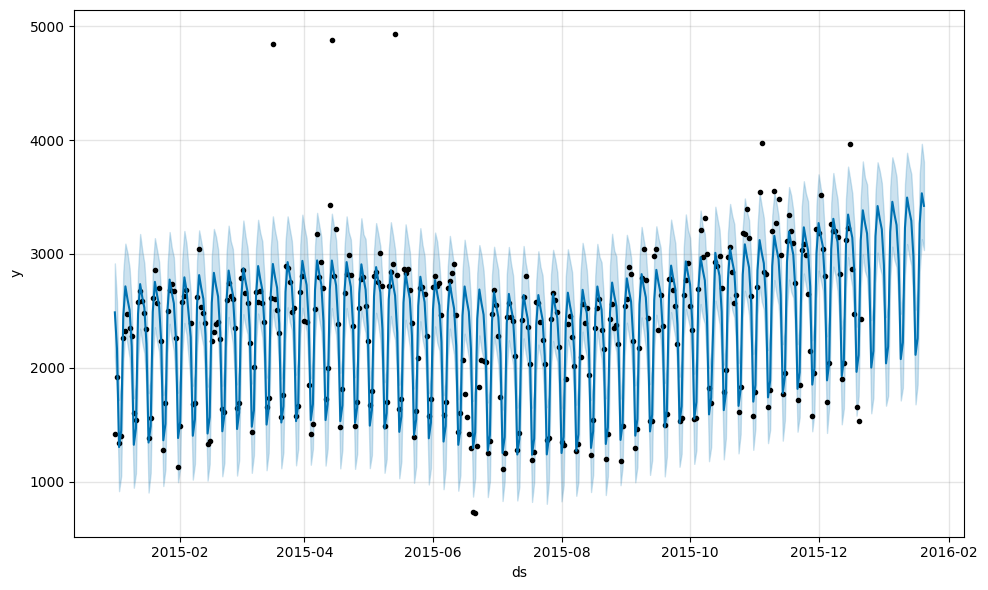

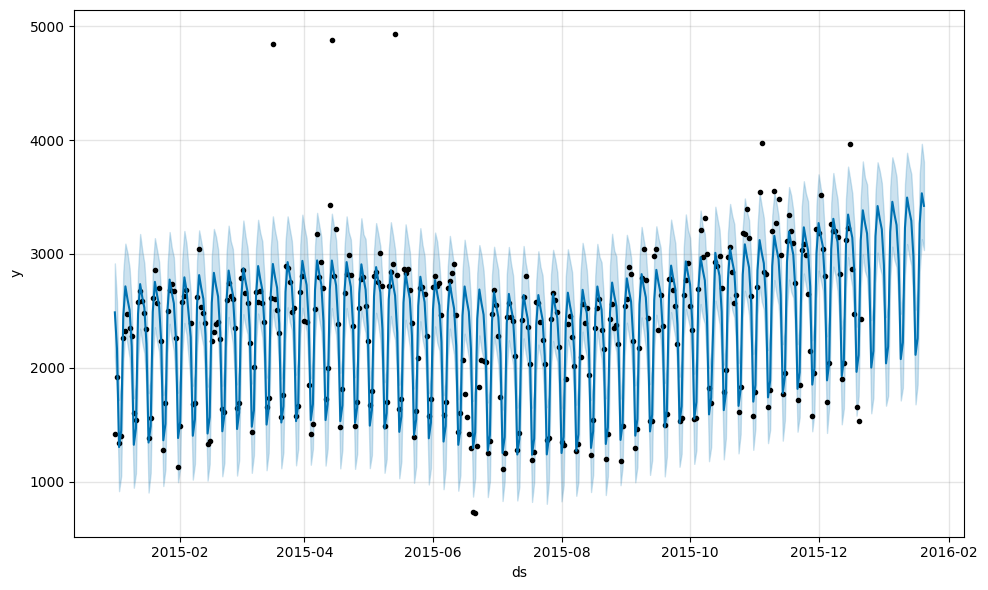

In [29]:
m.plot(forecast)

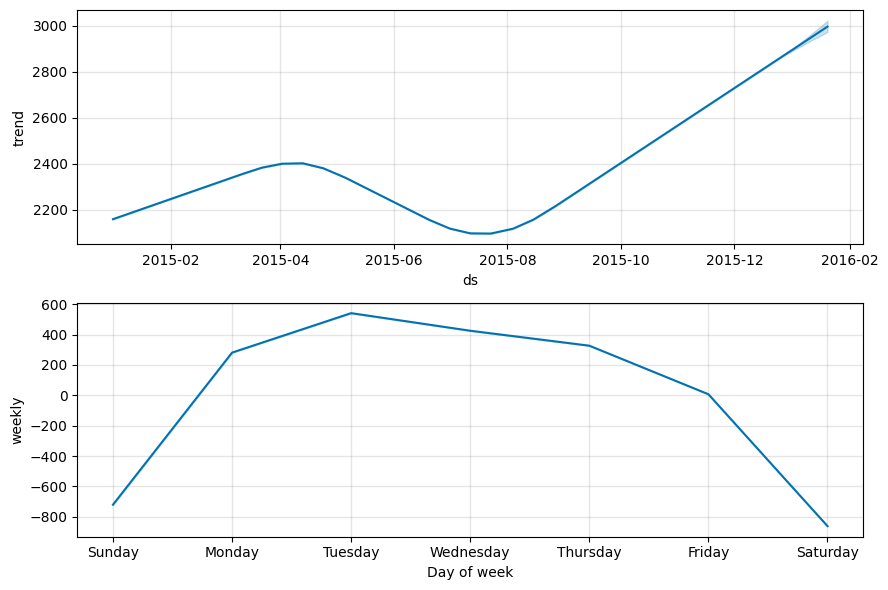

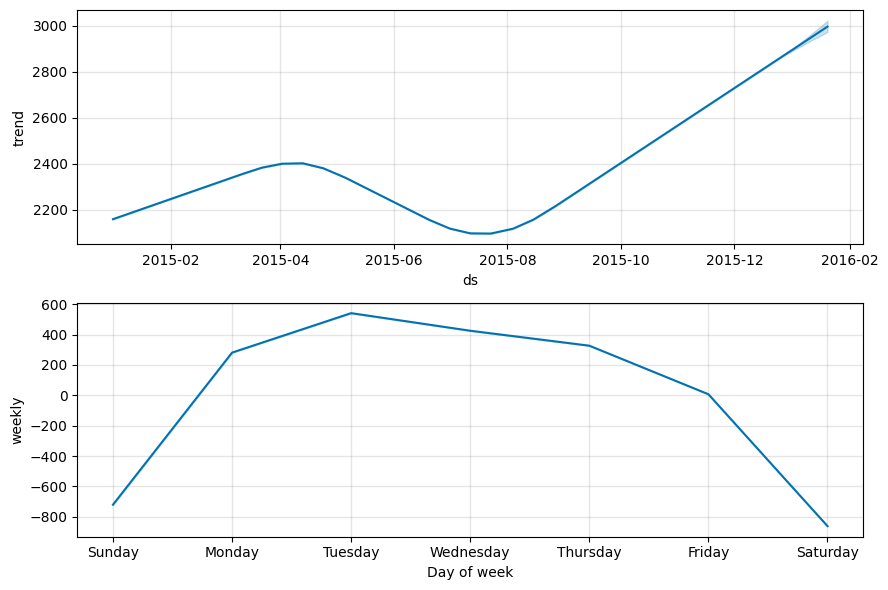

In [30]:
m.plot_components(forecast)

In [31]:
cmp_df = forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(df.set_index('ds'))

In [32]:
import numpy as np
cmp_df['e'] = cmp_df['y'] - cmp_df['yhat']
cmp_df['p'] = 100 * cmp_df['e'] / cmp_df['y']
print('MAPE = ', round(np.mean(abs(cmp_df[-predictions:]['p'])), 2))
print('MAE = ', round(np.mean(abs(cmp_df[-predictions:]['e'])), 2))

MAPE =  34.35
MAE =  596.54


Estimate the quality of the prediction with the last 30 points.

Question 2: What is MAPE equal to?

34.5

Question 3: What is MAE equal to?

600

## Predicting with ARIMA

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
plt.rcParams['figure.figsize'] = (15, 10)

Question 4: Let's verify the stationarity of the series using the Dickey-Fuller test. Is the series stationary? What is the p-value?

Series is not stationary, p_value = 0.107

Dickey-Fuller test: p=0.107392


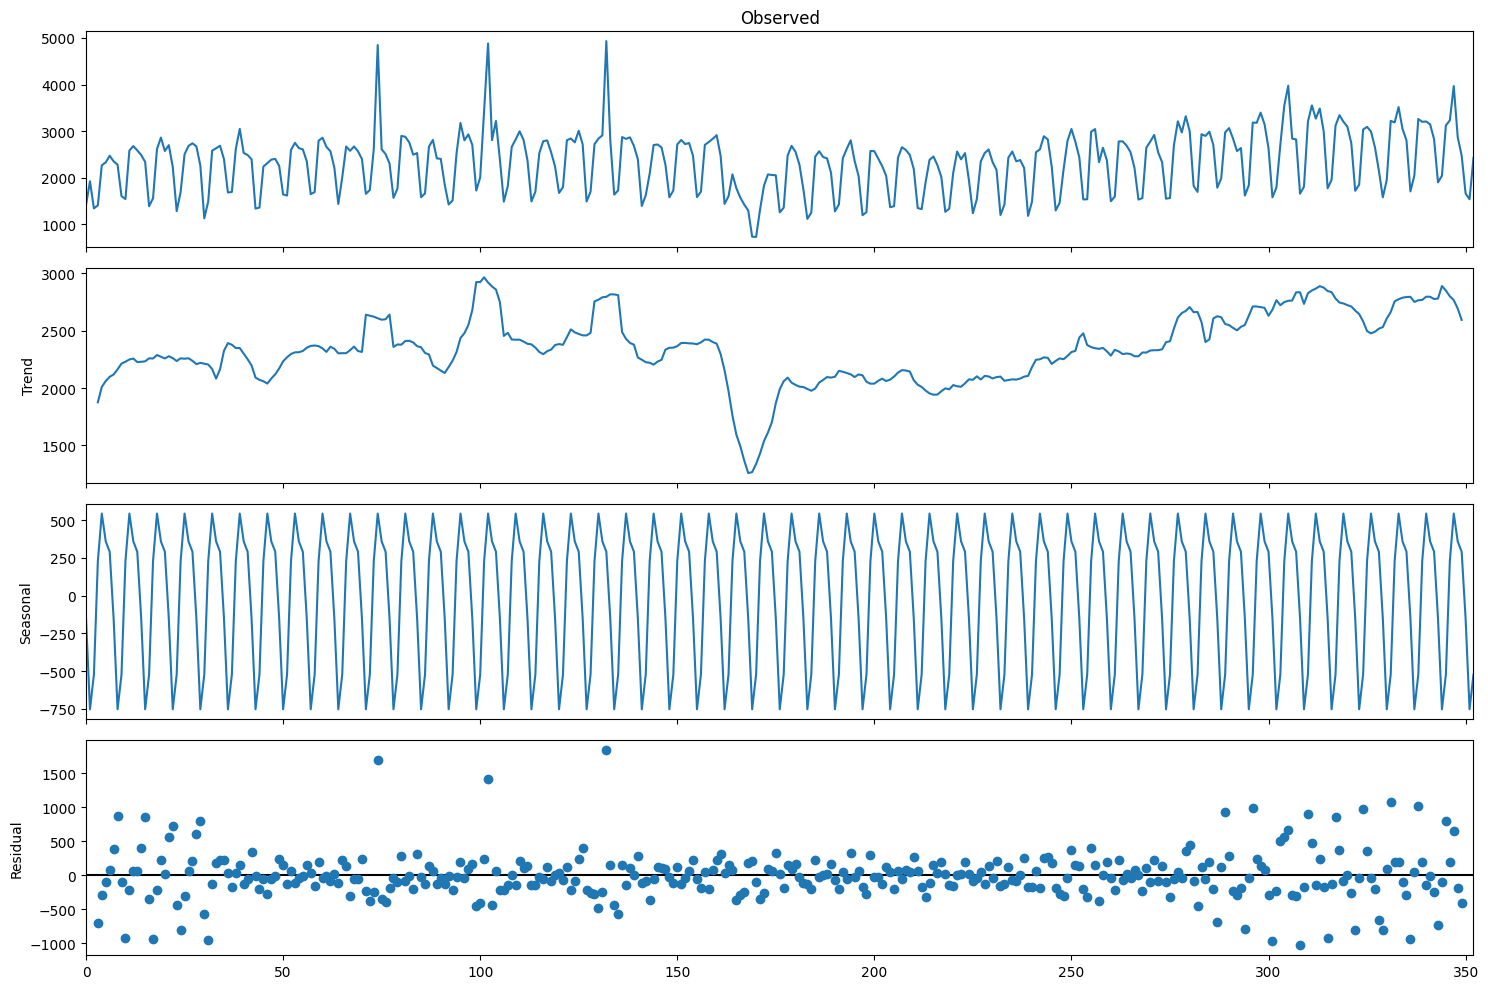

In [ ]:
sm.tsa.seasonal_decompose(train_df['y'].values, period=7).plot()
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df['y'])[1])

But the seasonally differentiated series will already be stationary.

In [ ]:
train_df.set_index('ds', inplace=True)

Dickey-Fuller test: p=0.000000


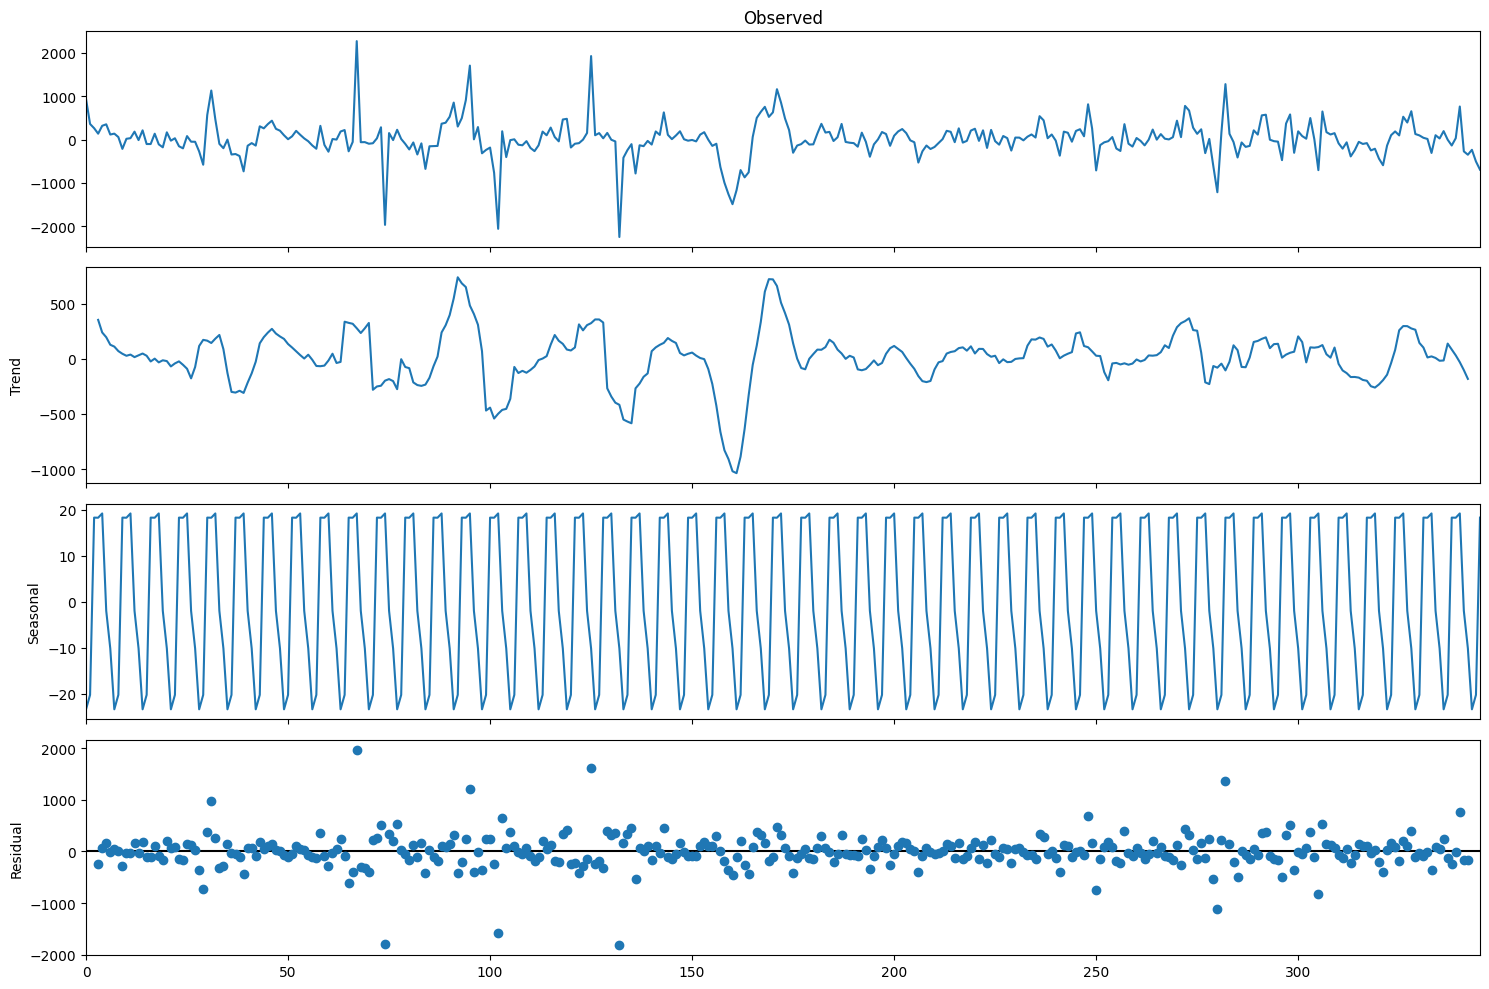

In [ ]:
train_df['y_diff'] = train_df.y - train_df.y.shift(7)
sm.tsa.seasonal_decompose(train_df.y_diff[7:].values, period=7).plot();
print("Dickey-Fuller test: p=%f" % sm.tsa.stattools.adfuller(train_df.y_diff[8:])[1])

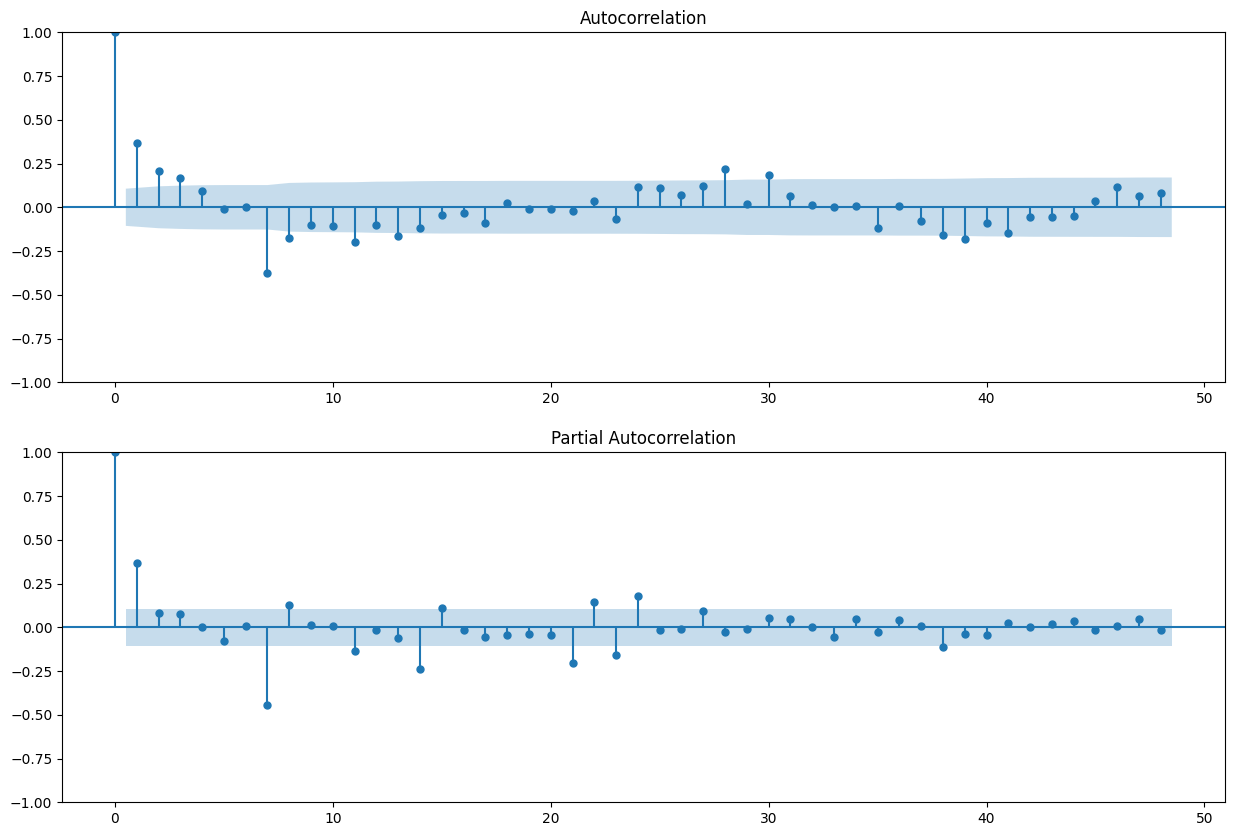

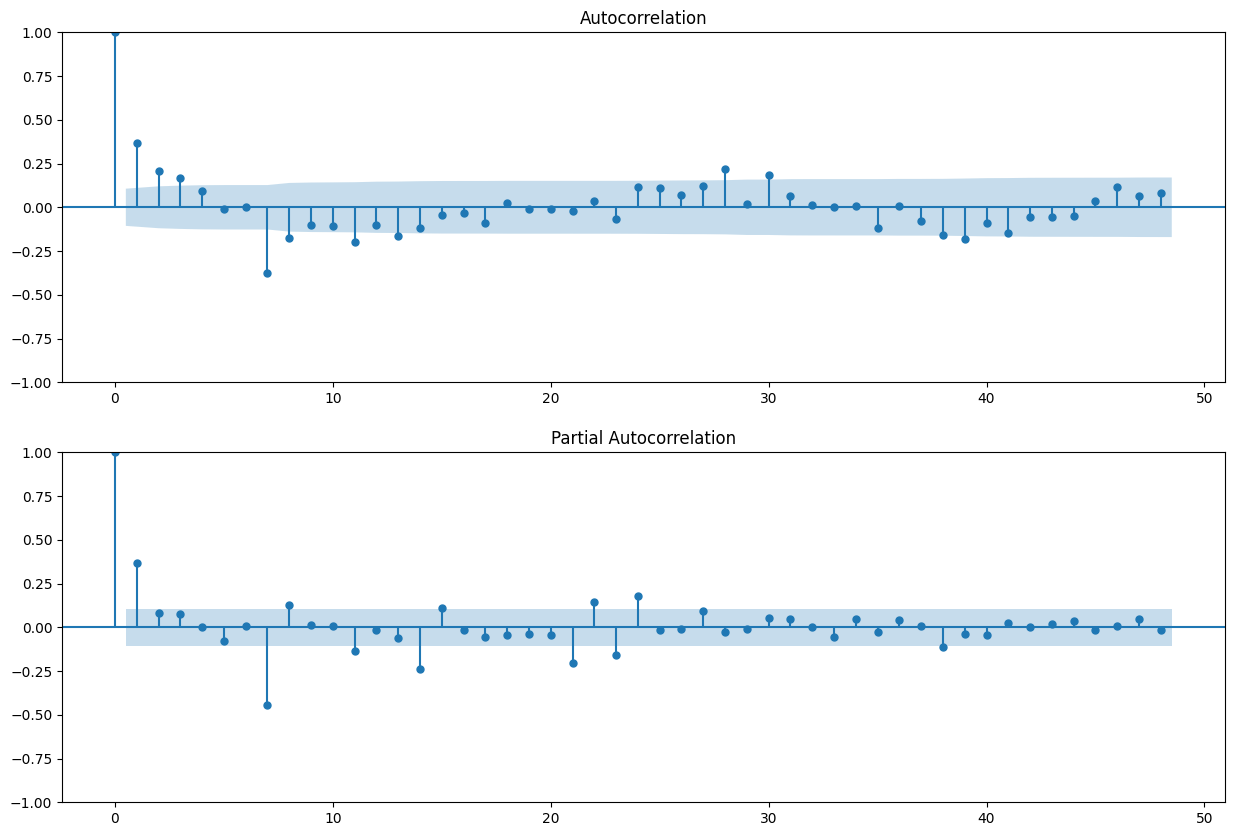

In [ ]:
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(train_df.y_diff[13:].values.squeeze(), lags=48, ax=ax)

Initial values:
* Q = 1
* q = 3
* P = 3
* p = 1

In [ ]:
ps = range(0, 2)
ds = range(0, 2)
qs = range(0, 4)
Ps = range(0, 4)
Ds = range(0, 3)
Qs = range(0, 2)

In [ ]:
from itertools import product

parameters = product(ps, ds, qs, Ps, Ds, Qs)
parameters_list = list(parameters)
len(parameters_list)

384

In [46]:
%%time
import warnings
from tqdm import tqdm
results1 = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results1.append([param, model.aic])

100%|██████████| 384/384 [31:13<00:00,  4.88s/it] 

CPU times: user 4h 4min 52s, sys: 1min 49s, total: 4h 6min 42s
Wall time: 31min 13s


In [47]:
result_table1 = pd.DataFrame(results1)
result_table1.columns = ['parameters', 'aic']
print(result_table1.sort_values(by = 'aic', ascending=True).head())

             parameters        aic
59   (0, 0, 2, 2, 0, 0)  10.000000
42   (0, 0, 1, 3, 0, 1)  12.000000
66   (0, 0, 2, 3, 0, 1)  14.000000
330  (1, 1, 1, 3, 0, 1)  14.000000
378  (1, 1, 3, 3, 0, 1)  52.721213


If we consider the variants proposed in the form:

In [48]:
result_table1[result_table1['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])]

,parameters,aic
257,"(1, 0, 2, 3, 0, 0)",5183.584907
259,"(1, 0, 2, 3, 1, 0)",5022.312524
356,"(1, 1, 2, 3, 1, 1)",5019.555903
358,"(1, 1, 2, 3, 2, 1)",4988.989473


Now do the same, but for the series with Box-Cox transformation.

In [49]:
import scipy.stats
train_df['y_box'], lmbda = scipy.stats.boxcox(train_df['y']) 
print("The optimal Box-Cox transformation parameter: %f" % lmbda)

The optimal Box-Cox transformation parameter: 0.732841


In [50]:
results2 = []
best_aic = float("inf")

for param in tqdm(parameters_list):
    #try except is necessary, because on some sets of parameters the model can not be trained
    try:
        model=sm.tsa.statespace.SARIMAX(train_df['y_box'], order=(param[0], param[1], param[2]), 
                                        seasonal_order=(param[3], param[4], param[5], 7)).fit(disp=-1)
    #print parameters on which the model is not trained and proceed to the next set
    except (ValueError, np.linalg.LinAlgError):
        continue
    aic = model.aic
    #save the best model, aic, parameters
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results2.append([param, model.aic])
    
warnings.filterwarnings('default')

100%|██████████| 384/384 [19:00<00:00,  2.97s/it]


In [51]:
result_table2 = pd.DataFrame(results2)
result_table2.columns = ['parameters', 'aic']
print(result_table2.sort_values(by = 'aic', ascending=True).head())

             parameters          aic
231  (1, 0, 1, 2, 2, 1)   191.832734
261  (1, 0, 2, 3, 2, 1)  3528.651466
213  (1, 0, 0, 3, 2, 1)  3530.524901
380  (1, 1, 3, 3, 2, 1)  3531.815405
237  (1, 0, 1, 3, 2, 1)  3532.092932


If we consider the variants proposed in the form:

In [52]:
result_table2[result_table2['parameters'].isin([(1, 0, 2, 3, 1, 0),
                                                (1, 1, 2, 3, 2, 1),
                                                (1, 1, 2, 3, 1, 1),
                                                (1, 0, 2, 3, 0, 0)])].sort_values(by='aic')

,parameters,aic
356,"(1, 1, 2, 3, 2, 1)",3534.540843
258,"(1, 0, 2, 3, 1, 0)",3556.880696
355,"(1, 1, 2, 3, 1, 1)",3557.853089
256,"(1, 0, 2, 3, 0, 0)",3674.916805


Question 5: What parameters are the best for the model according to the `AIC` criterion?
D = 2, d = 1, Q = 1, q = 2, P = 3, p = 1